In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import resnet18, vgg16, inception_v3, densenet161
import time

100%|██████████| 562M/562M [02:15<00:00, 4.14MB/s] 


Количество классов: 47
Размер тренировочного набора: 112800
Размер тестового набора: 18800
Классы: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']

Распределение классов в тренировочном наборе:
Класс 0 (0): 2400 примеров
Класс 1 (1): 2400 примеров
Класс 2 (2): 2400 примеров
Класс 3 (3): 2400 примеров
Класс 4 (4): 2400 примеров
Класс 5 (5): 2400 примеров
Класс 6 (6): 2400 примеров
Класс 7 (7): 2400 примеров
Класс 8 (8): 2400 примеров
Класс 9 (9): 2400 примеров
Класс 10 (A): 2400 примеров
Класс 11 (B): 2400 примеров
Класс 12 (C): 2400 примеров
Класс 13 (D): 2400 примеров
Класс 14 (E): 2400 примеров
Класс 15 (F): 2400 примеров
Класс 16 (G): 2400 примеров
Класс 17 (H): 2400 примеров
Класс 18 (I): 2400 примеров
Класс 19 (J): 2400 примеров
Класс 20 (K): 2400 примеров
Класс 21 (L): 2400 примеров
Класс 22 (M)

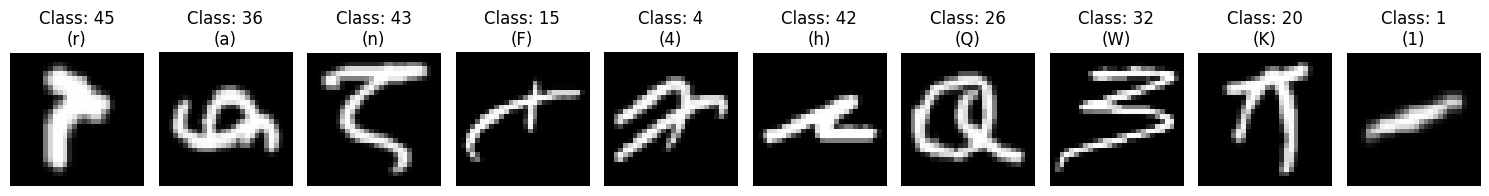

In [2]:
# 1. Загрузка и анализ датасета EMNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Загрузка EMNIST (используем split 'balanced' для сбалансированных классов)
train_dataset = torchvision.datasets.EMNIST(
    root='./data', 
    split='balanced',
    train=True, 
    download=True, 
    transform=transform
)

test_dataset = torchvision.datasets.EMNIST(
    root='./data', 
    split='balanced',
    train=False, 
    download=True, 
    transform=transform
)

# Посмотрим на информацию о датасете
print(f"Количество классов: {len(train_dataset.classes)}")
print(f"Размер тренировочного набора: {len(train_dataset)}")
print(f"Размер тестового набора: {len(test_dataset)}")
print(f"Классы: {train_dataset.classes}")

# Проверим дисбаланс классов
class_counts = {}
for _, label in train_dataset:
    class_counts[label] = class_counts.get(label, 0) + 1

print("\nРаспределение классов в тренировочном наборе:")
for i, count in enumerate(class_counts.values()):
    print(f"Класс {i} ({train_dataset.classes[i]}): {count} примеров")

# Визуализация примеров изображений
def show_examples(dataset, num_examples=10):
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 3))
    for i in range(num_examples):
        img, label = dataset[i]
        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].set_title(f'Class: {label}\n({train_dataset.classes[label]})')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_examples(train_dataset)

In [3]:
# 2. Создаем DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# 3. Функции для обучения и оценки
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Для Inception v3 нужны особые входные данные
        if isinstance(model, torchvision.models.Inception3):
            # Inception ожидает 3 канала и размер 299x299
            images = images.repeat(1, 3, 1, 1)  # 1 канал -> 3 канала
            images = torch.nn.functional.interpolate(images, size=(299, 299))
            
            optimizer.zero_grad()
            outputs, aux_outputs = model(images)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.4 * loss2
        else:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            if isinstance(model, torchvision.models.Inception3):
                images = images.repeat(1, 3, 1, 1)
                images = torch.nn.functional.interpolate(images, size=(299, 299))
                outputs = model(images)
            else:
                outputs = model(images)
            
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    test_loss = running_loss / len(test_loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

In [7]:
# 4. Функция для создания и модификации моделей
def create_model(model_name, num_classes):
    if model_name == 'resnet18':
        model = resnet18(weights=None)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'vgg16':
        model = vgg16(weights=None)
        model.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        model.classifier[6] = nn.Linear(4096, num_classes)
    elif model_name == 'inception_v3':
        model = inception_v3(weights=None, aux_logits=True)
        model.Conv2d_1a_3x3.conv = nn.Conv2d(1, 32, kernel_size=3, stride=2, bias=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)
    elif model_name == 'densenet161':
        model = densenet161(weights=None)
        model.features.conv0 = nn.Conv2d(1, 96, kernel_size=7, stride=2, padding=3, bias=False)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    
    return model

In [8]:
# 5. Эксперименты с разными архитектурами
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

num_classes = len(train_dataset.classes)
num_epochs = 3

models_to_train = ['resnet18', 'vgg16', 'inception_v3', 'densenet161']
results = {}

for model_name in models_to_train:
    print(f"\n{'='*50}")
    print(f"Training {model_name}")
    print(f"{'='*50}")
    
    # Создаем модель
    model = create_model(model_name, num_classes)
    model = model.to(device)
    
    # Критерий и оптимизатор
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
    
    # Списки для сохранения результатов
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    training_times = []
    
    # Обучение
    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = test_model(model, test_loader, criterion, device)
        
        epoch_time = time.time() - start_time
        training_times.append(epoch_time)
        
        scheduler.step()
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] - Time: {epoch_time:.2f}s')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        print('-' * 40)
    
    # Сохраняем результаты
    results[model_name] = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs,
        'training_times': training_times,
        'final_test_acc': test_accs[-1]
    }
    
    print(f"\nFinal Test Accuracy for {model_name}: {test_accs[-1]:.2f}%")


Using device: cpu

Training resnet18


\\aeoncorp.ru\files\Profiles\pokhiliy_ey\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
\\aeoncorp.ru\files\Profiles\pokhiliy_ey\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# 6. Визуализация результатов
plt.figure(figsize=(15, 10))

# Графики потерь
plt.subplot(2, 2, 1)
for model_name, result in results.items():
    plt.plot(result['train_losses'], label=f'{model_name} Train', linestyle='-')
    plt.plot(result['test_losses'], label=f'{model_name} Test', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)

# Графики точности
plt.subplot(2, 2, 2)
for model_name, result in results.items():
    plt.plot(result['train_accs'], label=f'{model_name} Train', linestyle='-')
    plt.plot(result['test_accs'], label=f'{model_name} Test', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.grid(True)

# Время обучения
plt.subplot(2, 2, 3)
avg_times = [np.mean(result['training_times']) for result in results.values()]
plt.bar(results.keys(), avg_times)
plt.xlabel('Model')
plt.ylabel('Average Time per Epoch (s)')
plt.title('Training Time per Epoch')
plt.xticks(rotation=45)

# Финальная точность
plt.subplot(2, 2, 4)
final_accs = [result['final_test_acc'] for result in results.values()]
plt.bar(results.keys(), final_accs)
plt.xlabel('Model')
plt.ylabel('Final Test Accuracy (%)')
plt.title('Final Test Accuracy')
plt.xticks(rotation=45)
plt.axhline(y=max(final_accs), color='r', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('emnist_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# 7. Сводная таблица результатов
print("\n" + "="*80)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print("="*80)

print(f"{'Model':<15} {'Final Train Acc':<15} {'Final Test Acc':<15} {'Avg Time/Epoch':<15}")
print("-" * 60)

for model_name, result in results.items():
    print(f"{model_name:<15} {result['train_accs'][-1]:<15.2f} {result['test_accs'][-1]:<15.2f} {np.mean(result['training_times']):<15.2f}")

# Находим лучшую модель
best_model = max(results.items(), key=lambda x: x[1]['final_test_acc'])
print(f"\nЛучшая модель: {best_model[0]} с точностью {best_model[1]['final_test_acc']:.2f}%")

# 8. Детальный анализ лучшей модели
print(f"\nДетальный анализ лучшей модели ({best_model[0]}):")
print(f"Количество параметров: {sum(p.numel() for p in best_model[0].parameters() if p.requires_grad):,}")
print(f"Общее время обучения: {sum(best_model[1]['training_times']):.2f} секунд")
print(f"Среднее время на эпоху: {np.mean(best_model[1]['training_times']):.2f} секунд")